# Short-term plasticity

In [1]:
import brainpy as bp
import numpy as np

import matplotlib.pyplot as plt

Let's first look at short-term plasticity. We will start with the results of the experiment. The figure shows the changes of the membrane potential of postsynaptic neurons as the firing of presynaptic neurons. We can see that when the presynaptic neurons repeatedly firing with short intervals, the response of the postsynaptic neurons becomes weaker and weaker, showing a short term depression. But the response recovers after a short period of time, so this plasticity is short-term.

<img src="stp.jpeg">


The formula of the model is as follows. Here, the short term plasticity is described mainly by variables $u$ and $x$. Where $u$ represents the probability of neurotransmitter release, the initial value is 0, and increase with the firing of presynaptic neurons, contributing to the short-term facilitation (STF); while $x$ represents the residual amount of neurotransmitters, the initial value is 1, and some of them will be used every time when presynaptic neurons fire, which means that it will decrease, contributing to the short-term depression (STD). Therefore the two directions of facilitation and depression occur simultaneously. $\tau_f$ and $\tau_d$ controls the recovery speed of $u$ and $x$, respectively, and the relationship between them determines which direction of plasticity plays a dominant role.

$$\frac{d u}{d t}= -\frac{u}{\tau_{f}}+U\left(1-u^{-}\right) \delta\left(t-t_{s p}\right)$$

$$\frac{d x}{d t}= \frac{1-x}{\tau_{d}}-u^{+} x^{-} \delta\left(t-t_{s p}\right)$$

$$\frac{d I}{d t}= -\frac{I}{\tau_{s}}+A u^{+} x^{-} \delta\left(t-t_{s p}\right)$$

$$u^{+}=u^{-}+U\left(1-u^{-}\right)$$

Or we can see the dynamics as:

$$
\frac {du} {dt} = - \frac u {\tau_f} 
$$

$$
\frac {dx} {dt} =  \frac {1-x} {\tau_d} 
$$

$$
\frac {dI} {dt} = - \frac I {\tau}
$$

$$
\rm{if (pre \ fire), then}
\begin{cases} 
u^+ = u^- + U(1-u^-) \\ 
I^+ = I^- + Au^+x^- \\
x^+ = x^- - u^+x^- 
\end{cases}
$$


The code implemented with BrainPy is as follows:

## LIF

In [2]:
class LIF(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  @staticmethod
  @bp.odeint(method='exponential_euler')
  def integral(V, t, Iext, V_rest, R, tau):
    dvdt = (-V + V_rest + R * Iext) / tau
    return dvdt

  def __init__(self, size, t_ref=1., V_rest=0., V_reset=0., 
               V_th=20., R=1., tau=10., **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)
    
    # parameters
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.R = R
    self.tau = tau
    self.t_ref = t_ref

    # variables
    self.t_last_spike = bp.ops.ones(self.num) * -1e7
    self.refractory = bp.ops.zeros(self.num, dtype=bool)
    self.spike = bp.ops.zeros(self.num, dtype=bool)
    self.V = bp.ops.ones(self.num) * V_rest
    self.input = bp.ops.zeros(self.num)

  def update(self, _t):
    for i in range(self.num):
      spike = False
      refractory = (_t - self.t_last_spike[i]) <= self.t_ref
      if not refractory:
        V = self.integral(self.V[i], _t, self.input[i],
                          self.V_rest, self.R, self.tau)
        spike = (V >= self.V_th)
        if spike:
          V = self.V_reset
          self.t_last_spike[i] = _t
          refractory = True
        self.V[i] = V
      self.spike[i] = spike
      self.refractory[i] = refractory
      self.input[i] = 0.

## STP

In [3]:
class STP(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    @bp.odeint(method='exponential_euler')
    def integral(s, u, x, t, tau, tau_d, tau_f):
        dsdt = -s / tau
        dudt = - u / tau_f
        dxdt = (1 - x) / tau_d
        return dsdt, dudt, dxdt
    
    def __init__(self, pre, post, conn, delay=0., U=0.15, tau_f=1500., tau_d=200., tau=8., A=1.,  **kwargs):
        # parameters
        self.tau_d = tau_d
        self.tau_f = tau_f
        self.tau = tau
        self.U = U
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
        self.num = len(self.pre_ids)

        # variables
        self.s = bp.ops.zeros(self.num)
        self.x = bp.ops.ones(self.num)
        self.u = bp.ops.zeros(self.num)
        self.A = A
        self.I_syn = self.register_constant_delay('I_syn', size=self.num, delay_time=delay)
        
        super(STP, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        for i in range(self.num):
            pre_id, post_id = self.pre_ids[i], self.post_ids[i]

            self.s[i], u, x = self.integral(self.s[i], self.u[i], self.x[i], _t, self.tau, self.tau_d, self.tau_f)
            if self.pre.spike[pre_id]:
                u += self.U * (1 - self.u[i])
                self.s[i] += self.A * u * self.x[i]
                x -= u * self.x[i]
            self.u[i] = u
            self.x[i] = x

            # output
            self.I_syn.push(i, self.s[i])
            self.post.input[post_id] += self.I_syn.pull(i)

## STD

When we set the parameters $\tau_d > \tau_f$, $x$ recovers very slowly, and $u$ decays very quickly, so in the end, the transmitter is not enough to open the receptors, showing STD dominants;

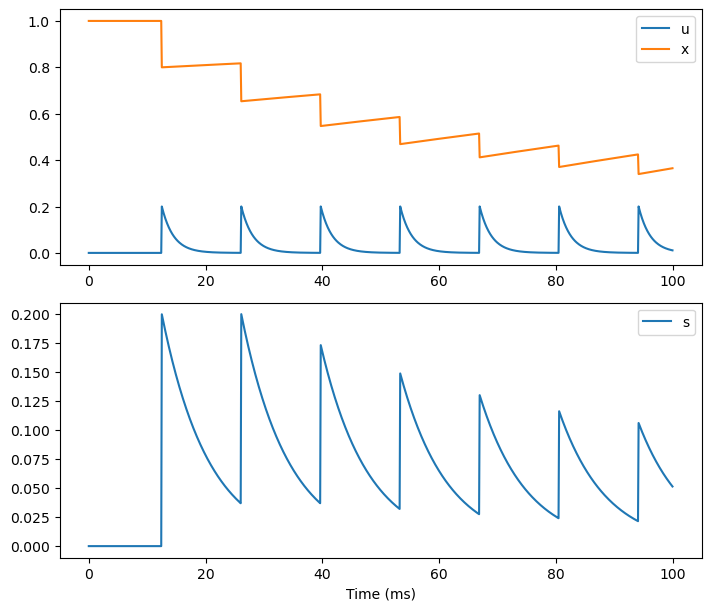

In [4]:
neu1 = LIF(1, monitors=['V'])
neu2 = LIF(1, monitors=['V'])

# STD
syn = STP(U=0.2, tau_d=150., tau_f=2., pre=neu1, post=neu2, 
          conn=bp.connect.All2All(), monitors=['s', 'u', 'x'])
net = bp.Network(neu1, syn, neu2)
net.run(100., inputs=(neu1, 'input', 28.))

# plot
fig, gs = bp.visualize.get_figure(2, 1, 3, 7)

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, syn.mon.u[:, 0], label='u')
plt.plot(net.ts, syn.mon.x[:, 0], label='x')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, syn.mon.s[:, 0], label='s')
plt.legend()

plt.xlabel('Time (ms)')
plt.show()

## STF

When $\tau_f > \tau_d$, on the contrary, every time $x$ is used, it will be added back quickly. There are always enough transmitters available. At the same time, the decay of $u$ is very slow, so the probability of releasing transmitters is getting higher and higher, showing STF dominants.

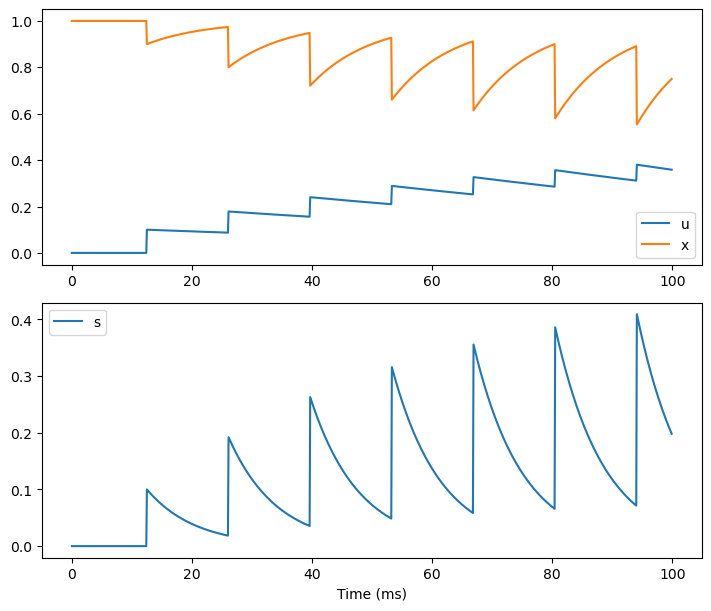

In [5]:
neu1 = LIF(1, monitors=['V'])
neu2 = LIF(1, monitors=['V'])

# STF
syn = STP(U=0.1, tau_d=10, tau_f=100., pre=neu1, post=neu2, 
          conn=bp.connect.All2All(), monitors=['s', 'u', 'x'])
net = bp.Network(neu1, syn, neu2)
net.run(100., inputs=(neu1, 'input', 28.))

# plot
fig, gs = bp.visualize.get_figure(2, 1, 3, 7)

fig.add_subplot(gs[0, 0])
plt.plot(net.ts, syn.mon.u[:, 0], label='u')
plt.plot(net.ts, syn.mon.x[:, 0], label='x')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(net.ts, syn.mon.s[:, 0], label='s')
plt.legend()

plt.xlabel('Time (ms)')
plt.show()